# Домашнее задание

- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [1]:
# !pip install catboost
# !pip install shap

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import catboost as catb
import shap
import itertools
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

%matplotlib inline

def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 

### 1. Взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

Возьмем Census Income Data Set

Abstract: Predict whether income exceeds $50K/yr based on census data. Also known as "Adult" dataset.

Data Set Information:

Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))

Prediction task is to determine whether a person makes over 50K a year.

In [3]:
data = pd.read_csv("adult.data")
# data = pd.read_csv("/content/sample_data/adult.data")


data.columns = ['age', 'workclass', 'fnlwgt', 'education',
              'education-num', 'marital-status', 'occupation',
              'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
              'hours-per-week', 'native-country', 'target']
data.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K


### 2. Cделать обзорный анализ выбранного датасета

In [4]:
print(data.shape)

(32560, 15)


Данные содержат 14 признаков и таргет в виде строки заработает ли человек более 50 000 или нет. Всего имееем 32560 записей.

Посмотрим на соотношение классов

In [5]:
data.iloc[:, -1].value_counts()

 <=50K    24719
 >50K      7841
Name: target, dtype: int64

In [6]:
data.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
target            object
dtype: object

In [7]:
data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


### 3. сделать feature engineering

Заменим таргет на бинарные признаки и проверим соотношение, что ничего не изменилось.

In [8]:
data['target'] = data['target'].apply(lambda x: 0 if x == ' <=50K' else 1)
data.iloc[:, -1].value_counts()

0    24719
1     7841
Name: target, dtype: int64

### 4. Обучить любой классификатор (какой вам нравится)

Разобъем выборку на тренировочную и тестовую

In [9]:
x_data = data.iloc[:,:-1]
y_data = data.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

In [10]:
cat_features = ['workclass', 
                'education', 
                'marital-status', 
                'occupation', 
                'relationship', 
                'race',
                'sex',
                'native-country']

model = catb.CatBoostClassifier(random_state=42, cat_features=cat_features, silent=True)

model.fit(x_train, y_train)
y_predict = model.predict(x_test)

evaluate_results(y_test, y_predict)


Classification results:
f1: 72.20%
roc: 80.54%
recall: 67.13%
precision: 78.09%


### 5. Разобраться с SHAP и построить важности признаков для:
### - всего тестового набора данных (summary_plot - дать интерпретацию)

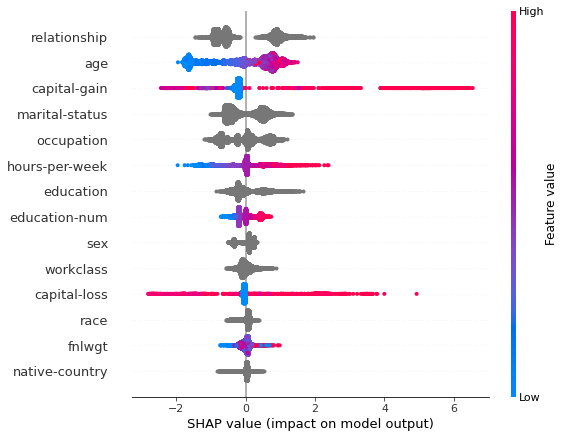

In [11]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train)

Сначала пройдемся по понятным значениям:

- Возраст - чем моложе, тем меньше вероятность, что человек накопит 50к за год
- Накопления - чем их больше, тем больше вероятность набрать 50к за год. Но так же значения приближенные к большим намекают, что у человека есть шанс не накопить.
- Чем больше часов в неделю человек работает, тем больше вероятность, что он накопит.
- чем выше уровень образования, тем больше вероятность накопить.
- с убытком совсем все неоднозначно. высокий убыток относится как позитиву так и к негативу, кроме значений близкий к вертикаьлной оси.
- fnlwght - все в перемешку.

А вот с серыми зонами видно, что влияют своей интенсивностью, но мы не понимаем из значения, т.к. catboost работает с категориальными признаками не трансформируя их. В этой ситуации можно поробовать интерпретировать показания через гистограмму, построив соответствующие значения.


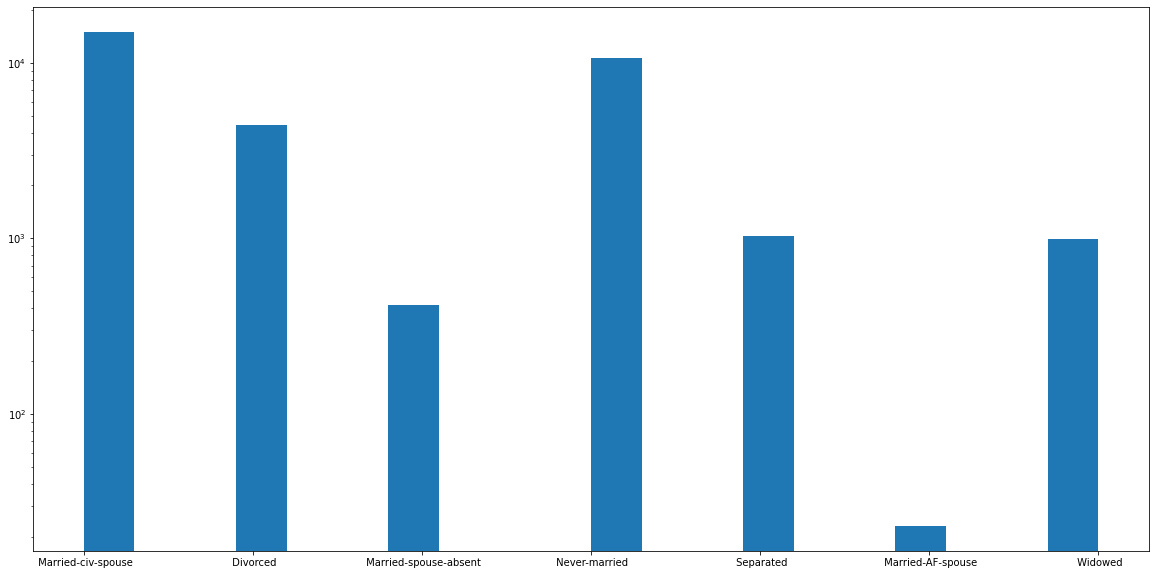

In [12]:
plt.figure(figsize=(20,10))
plt.hist(data['marital-status'], bins=20, log=True)
plt.show()

так по признаку matital-status видим, что гражданские супруги и разведенные не имеют шансов накопить 50к в отличие от ниразу не женатых и "разделенных"

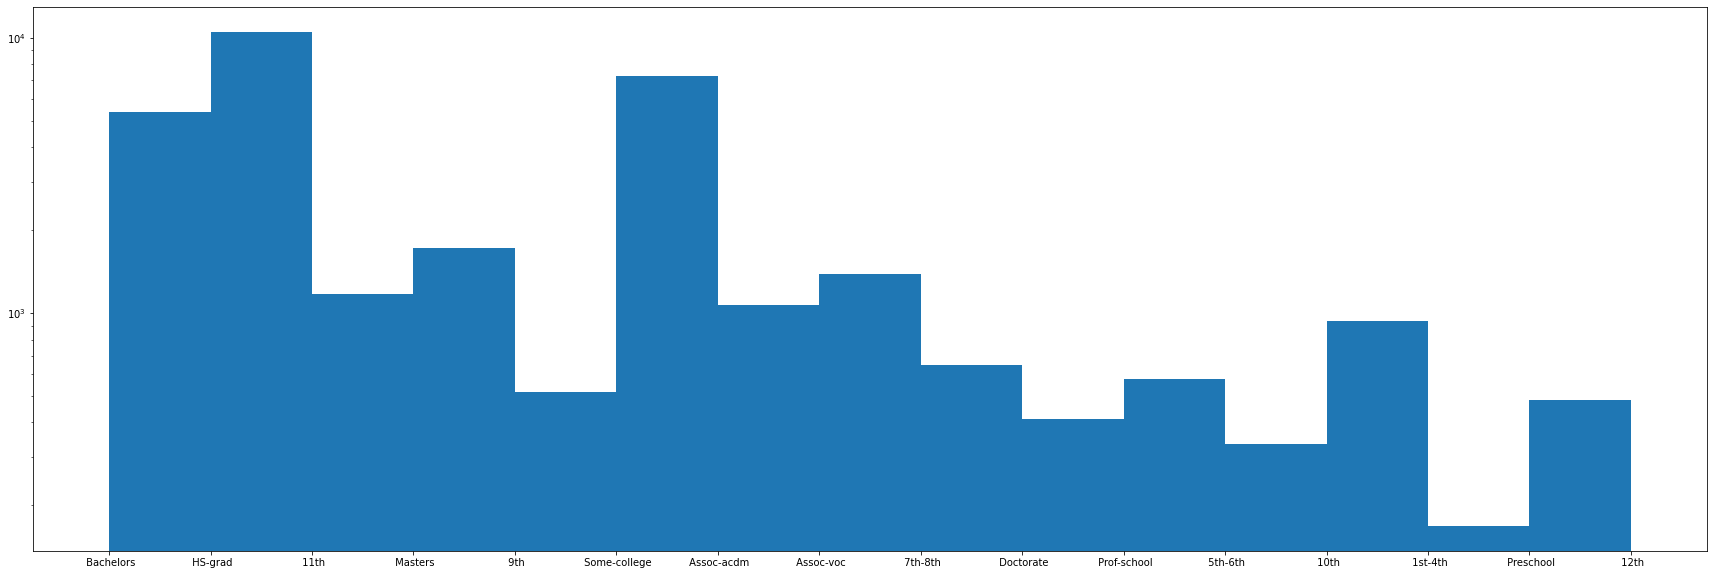

In [13]:
plt.figure(figsize=(30,10))
plt.hist(data['education'], bins=15, log=True)
plt.show()

в случае с образованием все неоднозначно. складывается впечатление, что мы ошибаемся в суждениях сравнивая распределение значение и SHAP показателей.

### Вывод, надо переводить категориальные переменные в вещественные.

Посмотрим дополнительно важность признаков

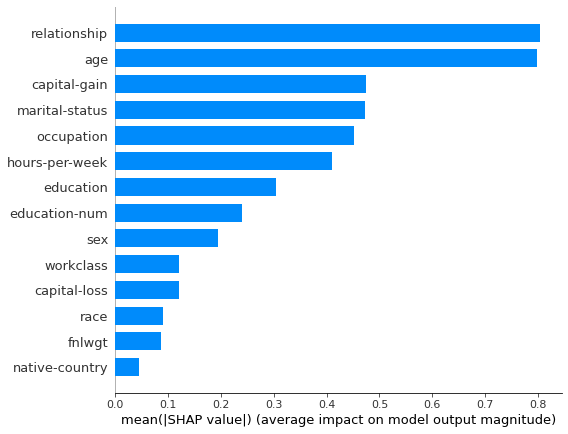

In [14]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

Комментарии излишни.

### - для топ 10%

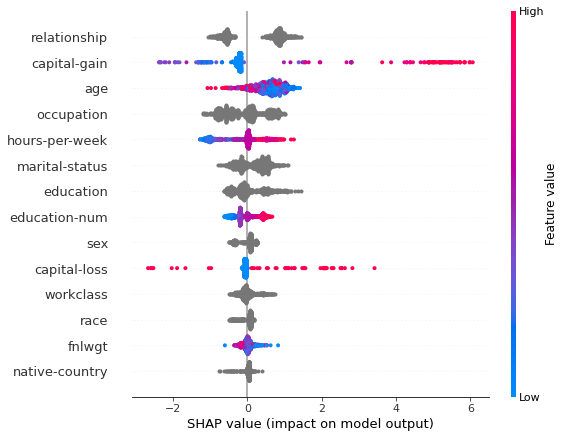

In [15]:
top10_age = x_test.sort_values(by='age', ascending=False).iloc[:int(x_test.shape[0] * .1)]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(top10_age)
shap.summary_plot(shap_values, top10_age)

На 10% данных показания стали более различимы по значениям.

In [16]:
# load JS visualization code to notebook
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

In [17]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[1000,:])

In [18]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[10000,:])

Собственно на всех трех графиках мы видим влияние показателей, как они приводят к среднему значени. Например для первого графика сильное влияние оказывают фичи, что человек является исполнительным менеджером, некий образовательный номер, а так же что он мужчина. Против него играет, что он без семьи, никогда не был женат и не имеет накоплений.